## Extract the subjects view

In [1]:
import os
import scipy.io as sio
import numpy as np

In [2]:
def handle_subj_ops(subj):
    subj_file = os.path.join(src_fold, 'subject' + format(subj)+ '.mat')
    data = sio.loadmat(subj_file)['A']
    # eliminate unwanted regions
    #data = data[:, mask]

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #os.mkdir(subj_dest_fold)
    return data


In [3]:
def extract_subj_store(subj, data):

    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    #Proceeded by transpose  to obtain 4 matrices for each subject, already checked that it is symmetric
    data=data.transpose(2,0,1)
    #the first matrix (network) in the dataset (over 4)
    #upper_tri=np.triu(data[0])
    matrix=data[0]
    #Vectorize 
    ui=np.triu_indices(35)
    vector=matrix[ui]
    

    #f = os.path.join(subj_dest_fold, 'subjectA'+ format(subj)  + '.mat' )
    ## needed data for classification, labels and features(brain grahps' weights in our case)
    #d = {}
    #d ['vector']=vector
    #sio.savemat(f,d)
    return vector

In [4]:
def create_dataset(subjects,src_fold,dst_fold):
    #subj_dest_fold = os.path.join(dst_fold, 'subject' + format(subj))
    d={}
    Features_vectors=[0 for i in range(630)]
    #v=np.array([[0 for i in range(630)]])
    for subj in subjects:
        subj_data=handle_subj_ops(subj)
        vector=extract_subj_store(subj,subj_data)
        Features_vectors=np.vstack((Features_vectors,vector))
        
        #v=np.append(v,np.array(vector))
        #d['subject'+format(subj)]=vector
    #d['A']=v
    Features_vectors=np.delete(Features_vectors,0,0)
    d['Features_vectors_RH']=Features_vectors
    f = os.path.join(dst_fold, 'Feature_vectors_RH' + '.mat' )
    sio.savemat(f,d)    
    

### --------------------Main------------------------

In [6]:
src_fold  = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/RH77subjects/'
label_file = '/home/raoua/Desktop/BASIRA/working repo/Data_77subjects/labels77.mat'
dst_fold = '/home/raoua/Desktop/BASIRA/working repo/intermediate_RH/'

In [8]:
subjects=range(1,78)
#for subj in subjects:
#    # read and create necessary folders
#    subj_data = handle_subj_ops(subj)
#    extract_subj_store(subj, subj_data)
create_dataset(subjects,src_fold,dst_fold)

### Start over here 

In [1]:
import scipy.io as sio

In [10]:
Data=sio.loadmat('./intermediate_RH/Feature_vectors_RH.mat')

In [11]:
X=Data['Features_vectors_RH']

In [12]:
X = X.astype(float)

In [13]:
labels=sio.loadmat('./labels77.mat')

In [14]:
y=labels['labels']

In [15]:
X.dtype

dtype('float64')

### Feature selection

In [16]:
y=y[:, 0]

In [17]:
 n_samples, n_features = X.shape    # number of samples and number of features

In [18]:
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score
from skfeature.function.similarity_based import reliefF

### 5-fold

In [19]:
# split data into 5 folds
kf5=KFold(n_splits=5,shuffle=True)

#ss = cross_validate(n_samples, n_folds=5, shuffle=True)

In [20]:
kf5.get_n_splits(X)

5

In [21]:
# Number of selected features (top k ranked features)

#top K selected features varying from 10 to 100 (with a step size of 10 features)
num_fea = [i for i in range(10,110,10)]
clf = svm.LinearSVC()    # linear SVM
correct=0
accuracy=[]

In [22]:
#MutInfFS
from skfeature.function.information_theoretical_based import MIFS
#laplacian
from skfeature.function.similarity_based import lap_score
from skfeature.utility import construct_W
# norm
from skfeature.function.sparse_learning_based import ll_l21
from skfeature.utility.sparse_learning import *
#UDFS
from skfeature.function.sparse_learning_based import UDFS
from skfeature.utility.sparse_learning import feature_ranking
#cFS(correlation based FS)
from skfeature.function.statistical_based import CFS

In [23]:
def relief_FS(X_train,y_train):
    score=reliefF.reliefF(X_train,y_train)
    idx=reliefF.feature_ranking(score)
    return(idx)

In [24]:
def MIFS_FS(k,X_train,y_train):
    idx = MIFS.mifs(X_train, y_train, n_selected_features=k)
    #print(idx)
    return(idx)

In [25]:
def lap_score_FS():
    # construct affinity matrix
    kwargs_W = {"metric": "euclidean", "neighbor_mode": "knn", "weight_mode": "heat_kernel", "k": 5, 't': 1}
    W = construct_W.construct_W(X, **kwargs_W)
    # obtain the scores of features
    score = lap_score.lap_score(X, W=W)
    idx=lap_score.feature_ranking(score)
    return(idx)

In [26]:
def ll_l21_FS(X_train,y,train_index):
    Y = construct_label_matrix_pan(y)
    Y_train=Y[train_index]
    Weight, obj, value_gamma = ll_l21.proximal_gradient_descent(X_train, Y[train_index], 0.1, verbose=False)
    idx = feature_ranking(Weight)
    return(idx)
    
    

In [27]:
def UDFS_FS():
    Weight = UDFS.udfs(X)
    idx=feature_ranking(Weight)
    return(idx)
    

In [28]:
def CFS_FS(X_train,y_train):
    idx = CFS.cfs(X_train, y_train)
    return(idx)
    

In [29]:
def training(cv,num_fea,FS_method):
    accuracy=[]
    for k in num_fea: 
        for train_index, test_index in cv.split(X):
            #print("TRAIN:", train_index, "TEST:", test_index)
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
 
            if FS_method==reliefF:
                idx=relief_FS(X_train,y_train)
            #elif FS_method==MIFS: ##ERROR
            #    idx=MIFS_FS(k,X_train,y_train)
            elif FS_method==lap_score:
                idx=lap_score_FS()
            elif FS_method==ll_l21:
                idx=ll_l21_FS(X_train,y,train_index)
            elif FS_method==UDFS:
                idx=UDFS_FS()
            elif FS_method==CFS:
                idx=CFS_FS(X_train,y_train)
            selected_features = X[:, idx[0:k]]
            # train a classification model with the selected features on the training dataset
            clf.fit(selected_features[train_index], y[train_index])
            # predict the class labels of test data
            y_predict = clf.predict(selected_features[test_index])
            # obtain the classification accuracy on the test data
            acc = accuracy_score(y[test_index], y_predict)
            #correct = correct + acc
        #accuracy.append(float(correct)/10)
        accuracy.append(acc)
    #performance.append(accuracy)
    return(accuracy)

#### 10-Fold

In [30]:
#test=training(num_fea,reliefF)
# split data into 10 folds
kf10=KFold(n_splits=10,shuffle=True)

In [31]:
kf10.get_n_splits()

10

#### LOO

In [32]:
from sklearn.model_selection import LeaveOneOut
loo=LeaveOneOut()

In [33]:
loo.get_n_splits(X)

77

In [34]:
def main_pipeline(cv):
    performance=[]
    Pool_FS=[reliefF,lap_score,ll_l21,UDFS,CFS]
    for FS in Pool_FS:
        performance.append(training(cv,num_fea,FS))
    return(performance)
        

In [35]:
performance5=main_pipeline(kf5)

In [42]:
performance10=main_pipeline(kf10)

In [43]:
save_performance('10_fold_RH',dst_fold,performance10)

In [ ]:
performance_loo=main_pipeline(loo)

In [57]:
len(performance10)

5

In [36]:
def save_performance(file_name,dst_fold,performance):
    Pool_FS_names=['reliefF','lap_score','ll_l21','UDFS','CFS']
    d={}
    for name in Pool_FS_names:
        d[name]=performance[Pool_FS_names.index(name)]
    #dst_fold='/home/raoua/Desktop/BASIRA/working repo/intermediate/'
    f = os.path.join(dst_fold, file_name + '.mat' )
    sio.savemat(f,d)

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()
def plot_performance(result,num_fea):
    line1, = plt.plot(num_fea,result['reliefF'][0], label='reliefF')
    line2, = plt.plot(num_fea,result['lap_score'][0], marker='', label='lap_score')
    line3, = plt.plot(num_fea,result['ll_l21'][0], marker='', label='ll_l21')
    line4, = plt.plot(num_fea,result['UDFS'][0], marker='', label='UDFS')
    line5, = plt.plot(num_fea,result['CFS'][0], marker='', label='CFS')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.xlabel('Top k ranked features')
    plt.ylabel('Accuracy')
    #plt.title('Feature selection methods performance using 5-fold CV')

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


### -------------- Main Program ------------------

In [60]:
## import cv method here
import os
## cv=instance()
##dst_fold='bla/bla/bla'
#performance_x=main_pipeline(cv)
## due to the fact that this pipeline is time consuming I chose to save the results of the pipeline so 
## I don't have to rerun the whole pipeline from zero
dst_fold='/home/raoua/Desktop/BASIRA/working repo/intermediate/'
save_performance('Pool_FS_Accuracy_10fold',dst_fold,performance10)
## Read the performance result for later processing
#result_file= sio.loadmat('blalalalal')


In [44]:
import scipy.io as sio
result=sio.loadmat('./intermediate_RH/10_fold_RH.mat')

Text(0.5, 1.0, 'Feature selection methods performance using 10-fold CV: RH')

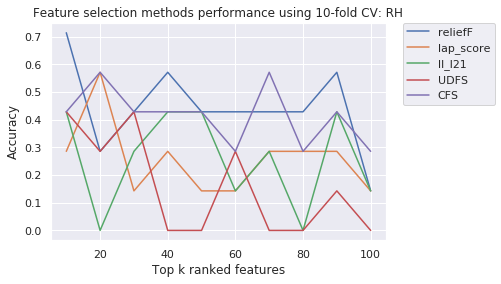

In [45]:
plot_performance(result,num_fea)
plt.title('Feature selection methods performance using 10-fold CV: RH')

### Plot the results

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
sns.set()

/usr/local/lib/python3.6/dist-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


Text(0.5, 1.0, 'Feature selection methods performance using 5-fold CV')

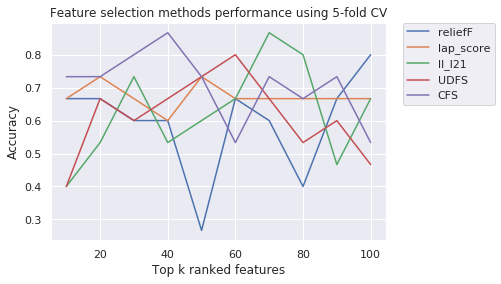

In [61]:
import matplotlib.pyplot as plt
#from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(num_fea,result['reliefF'][0], label='reliefF')
line2, = plt.plot(num_fea,result['lap_score'][0], marker='', label='lap_score')
line3, = plt.plot(num_fea,result['ll_l21'][0], marker='', label='ll_l21')
line4, = plt.plot(num_fea,result['UDFS'][0], marker='', label='UDFS')
line5, = plt.plot(num_fea,result['CFS'][0], marker='', label='CFS')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.xlabel('Top k ranked features')
plt.ylabel('Accuracy')
plt.title('Feature selection methods performance using 5-fold CV')